<a href="https://colab.research.google.com/github/alessandropacielli/autonomous_systems_project/blob/master/Pytorch_DQN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install dependencies for virtual display to render the environment

See [this medium post.](https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7)

In [ ]:
# This installs a 
!apt-get install -y xvfb x11-utils

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*

# This starts the display
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

In [8]:
from gym.wrappers.frame_stack import FrameStack
from gym.wrappers.gray_scale_observation import GrayScaleObservation
from collections import namedtuple
import gym
import math
import matplotlib.pyplot as plt
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from IPython import display

In [3]:
frames = 4
env_name = 'Breakout-v0'
env = FrameStack(GrayScaleObservation(gym.make(env_name)), frames)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Replay buffer

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# DQN module

In [5]:
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs, frame_stack=4, rgb=False):
        super(DQN, self).__init__()

        """
        Construct a new DQN object.
        
        :param h: The height of the image.
        :param w: The width of the image.
        :param outputs: The number of outputs.
        """

        if rgb:
          color_channels = 3
        else:
          color_channels = 1
        
        self.input_channels = color_channels * frame_stack

        self.conv1 = nn.Conv2d(self.input_channels, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # (Size - Kernel size + 2 * Padding) // Stride --> see https://cs231n.github.io/convolutional-networks/
        def conv2d_size_out(size, kernel=5, stride=2):
            return (size - kernel) // stride + 1
        
        # Compute convolution output dimensions
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        
        # Conv output width * conv output height * conv output channels
        self.linear_input_size = convw * convh * 32
                 
        # A fully connected layer for the output
        self.head = nn.Linear(self.linear_input_size, outputs)
        
    # NN forward pass    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # TODO should we use maxpooling? or any other pooling?
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [6]:
class DQNTraining():

  def __init__(self, env, batch_size=128, gamma=0.999,
                 eps_start=0.9, eps_end=0.05, eps_decay=200, 
                 update_every=10, memory_size=10000):
    """
    The training support object has two DQNs: policy and target, see 
    https://greentec.github.io/reinforcement-learning-third-en/#soft-update-target-network

    :param env: gym environment
    :param batch_size: how many transitions are sampled from the replay memory for training.
    :param gamma: discount.
    :param eps_start: initial exploration rate (for epsilon-greedy policy).
    :param eps_decay: controls the rate of decay (for epsilon-greedy policy).
    :param eps_end: final exploration rate (for epsilon-greedy policy).
    :param update_every: how often the target net is updated with weights from the policy network.
    :param memory_size: replay buffer size
    """

    self.env = env
    self.batch_size = batch_size
    self.gamma = gamma
    self.eps_start = eps_start
    self.eps_end = eps_end
    self.eps_decay = eps_decay
    self.update_every = update_every

    # Might be useful later on
    self.n_actions = env.action_space.n

    # State dimensions
    # TODO move outside!!!
    self.state_h = env.observation_space.shape[1]
    self.state_w = env.observation_space.shape[2]
    self.channels = 4

    # Policy & target nets
    self.policy_network = DQN(self.state_h, self.state_w, self.n_actions, rgb=False).to(device)
    self.target_network = DQN(self.state_h, self.state_w, self.n_actions, rgb=False).to(device)
    self.target_network.load_state_dict(self.policy_network.state_dict())
    self.target_network.eval()

    # Optimizer
    self.optimizer = optim.RMSprop(self.policy_network.parameters())

    # Replay memory
    self.memory = ReplayMemory(memory_size)

    self.total_steps = 0
    
    # Performance

  def select_action(self, state):
    sample = random.random()
    eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
                    math.exp(-1. * self.total_steps / self.eps_decay)
    self.total_steps += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return self.policy_network(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)


  def optimize_model(self):

    if len(self.memory) < self.batch_size:
        return
    
    # Optimization steps sample the replay buffer
    transitions = self.memory.sample(self.batch_size)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Convert arrays to tensors
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.tensor(batch.reward, device=device)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = [s for s in batch.next_state if s is not None]
    non_final_len = torch.sum(non_final_mask.long())
    non_final_next_states = torch.stack(non_final_next_states)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    print(self.policy_network(state_batch).shape)
    state_action_values = self.policy_network(state_batch).gather(1, action_batch)[non_final_mask]

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(self.batch_size, device=device)
    next_state_values = self.target_network(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * self.gamma) + reward_batch[non_final_mask]
    
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    for param in self.policy_network.parameters():
        param.grad.data.clamp_(-1, 1)
    self.optimizer.step()

  def training_loop(self, num_episodes, render=False):
    if render:
      _, ax = plt.subplots(1, 1)

    for episode in range(num_episodes):
      print('Episode: %d/%d' % (episode+1, num_episodes))
      # Reset env
      state = torch.tensor(env.reset(), device=device).view(self.channels, self.state_h, self.state_w).float()
      done = False
      if render:
        img = ax.imshow(env.render(mode='rgb_array'))      
      while not done:

        if render:
          img.set_data(env.render(mode='rgb_array')) 
          ax.axis('off')
          display.display(plt.gcf())
          display.clear_output(wait=True)
        
        # Let agent perform an action according to an eps-greedy policy
        action = self.select_action(state.view(1, self.channels, self.state_h, self.state_w))
        
        # Take step
        next_state, reward, done, _ = self.env.step(action)
        
        # Convert to tensors
        reward = torch.tensor([reward], device=device)
        
        if not done:
          next_state = torch.from_numpy(np.array(next_state)).to(device).view(self.channels, self.state_h, self.state_w).float()
        else:
          next_state = None
        
        # Remember transition
        self.memory.push(state, action, reward, next_state)

        # Run optimization step
        self.optimize_model()
        
      if episode % self.update_every == 0:
        self.target_network.load_state_dict(self.policy_network.state_dict())
          

In [7]:
agent = DQNTraining(env)
agent.training_loop(100, render=False)

Episode: 1/100
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([128, 4])


KeyboardInterrupt: 

In [ ]:
# TODO checkpointing
torch.save({
            'model_state_dict': agent.policy_network.state_dict(),
            'optimizer_state_dict': agent.optimizer.state_dict(),
            }, 'policy.pkl')

torch.save({
            'model_state_dict': agent.target_network.state_dict(),
            }, 'target.pkl')

In [ ]:
old_agent = DQNTraining(env, eps_start=0.05)
policy_checkpoint = torch.load('policy.pkl')
target_checkpoint = torch.load('target.pkl')
old_agent.policy_network.load_state_dict(policy_checkpoint['model_state_dict'])
old_agent.target_network.load_state_dict(target_checkpoint['model_state_dict'])
old_agent.optimizer.load_state_dict(policy_checkpoint['optimizer_state_dict'])

In [ ]:
old_agent.training_loop(1, render=True)

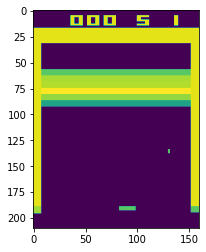

In [70]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(torch.from_numpy(np.array(env.step(env.action_space.sample())[0][0])))